# Predicción del riesgo de abandono académico en estudiantes universitarios

In [624]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Cargamos la base de datos "Predict Students' Dropout and Academic Success"

In [625]:
df = pd.read_csv('data\data.csv', sep=';')
df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


Revisamos el tipo de dato de las columnas del Dataframe.

In [626]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance	                     4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification                   

Observamos el número de valores únicos de cada variable.

In [627]:
df.nunique()

Marital status                                      6
Application mode                                   18
Application order                                   8
Course                                             17
Daytime/evening attendance\t                        2
Previous qualification                             17
Previous qualification (grade)                    101
Nacionality                                        21
Mother's qualification                             29
Father's qualification                             34
Mother's occupation                                32
Father's occupation                                46
Admission grade                                   620
Displaced                                           2
Educational special needs                           2
Debtor                                              2
Tuition fees up to date                             2
Gender                                              2
Scholarship holder          

### Renombrar columnas

Renombramos las columnas de modo que sea más fácil trabajar con ellas.

In [628]:
df = df.rename(columns={'Marital status': 'Marital', "Mother's occupation": 'Mother_occ', "Father's occupation": 'Father_occ', "Age at enrollment": 'Age'
                        , "Previous qualification": 'P_quali', 'Daytime/evening attendance\t': 'Attendance', "Mother's qualification": "Mother_quali",
                        "Father's qualification": "Father_quali"})

In [629]:
df['Target'].value_counts()

Target
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64

Observamos que la variable "Target" presenta tres categorías diferentes. Dado que el objetivo de este análisis es predecir si un estudiante abandona o no la institución, se decidió reclasificar los registros con estado "Enrolled" como "Graduate". Esto permite reducir el problema a dos categorías claramente definidas (retención y deserción), lo que facilita tanto el modelado como la interpretación de los resultados. Además, en el artículo introductorio de la base de datos, las categorías "Graduate" y "Enrolled" se utilizan para representar diferentes niveles de desempeño de estudiantes que no abandonaron la institución.

In [630]:
df['Target'] = df['Target'].replace('Enrolled', 'Graduate')

In [631]:
df['Target'].value_counts()

Target
Graduate    3003
Dropout     1421
Name: count, dtype: int64

In [632]:
variables_categoricas = ['Marital', 'Application mode', 'Application order', 'Course',
       'Attendance', 'P_quali', 
       'Nacionality', 'Mother_quali', 'Father_quali', 'Mother_occ',
       'Father_occ', 'Displaced',
       'Educational special needs', 'Debtor', 'Tuition fees up to date',
       'Gender', 'Scholarship holder', 'International']


Se creó una copia del DataFrame original con el propósito de realizar modificaciones sin alterar los datos fuente, garantizando la preservación de la información original. Posteriormente, se convirtieron las columnas categóricas a tipo string, con el fin de facilitar su posterior proceso de codificación.

In [633]:
df_copy = df.copy()
df_copy[variables_categoricas] = df_copy[variables_categoricas].astype('str')

In [634]:
variables_numericas = df_copy.select_dtypes(include=['int64', 'float64']).columns

Obsevamos el número de valores únicos en las variables categóricas.

In [635]:
df_copy[variables_categoricas].nunique()

Marital                       6
Application mode             18
Application order             8
Course                       17
Attendance                    2
P_quali                      17
Nacionality                  21
Mother_quali                 29
Father_quali                 34
Mother_occ                   32
Father_occ                   46
Displaced                     2
Educational special needs     2
Debtor                        2
Tuition fees up to date       2
Gender                        2
Scholarship holder            2
International                 2
dtype: int64

### Agrupar categorias en las variable categóricas

Dado que algunas variables categóricas presentan alta cardinalidad, con numerosas clases que cuentan con una única observación, se optó por agrupar dichas categorías poco frecuentes en una sola denominada "Otras".

In [636]:
for i in variables_categoricas:
    cats = df_copy[i].value_counts()
    top_cats = cats[cats > 15].index
    df_copy[i] = df_copy[i].where(df_copy[i].isin(top_cats), 'Otras')

In [637]:
df_copy[variables_categoricas].nunique()

Marital                       5
Application mode             14
Application order             7
Course                       17
Attendance                    2
P_quali                      10
Nacionality                   3
Mother_quali                 11
Father_quali                 12
Mother_occ                   14
Father_occ                   14
Displaced                     2
Educational special needs     2
Debtor                        2
Tuition fees up to date       2
Gender                        2
Scholarship holder            2
International                 2
dtype: int64

In [638]:
from sklearn.preprocessing import LabelEncoder

## Encoding variable Target

Se realizó la partición del conjunto de datos, separando la variable objetivo (Target) de las variables predictoras, con el fin de preparar la información para el modelado.

In [639]:
X = df_copy.drop('Target', axis=1)
y = df_copy['Target']

Se aplicó Label Encoding a la variable objetivo, dado que corresponde a una variable categórica binaria con dos clases (“Graduate” y “Dropout”), las cuales pueden representarse mediante valores numéricos 0 y 1 para un tratamiento más óptimo.

In [640]:
le = LabelEncoder()
y = le.fit_transform(y)

### Variables categóricas

Utilizamos Chi cuadrado con el fin de buscar la relación entre variables categóricas y la variable objetivo

In [641]:
from scipy.stats import chi2_contingency

resultados = {} 

for col in X[variables_categoricas]:
    tabla = pd.crosstab(X[col], y)  # tabla de contingencia
    chi2, p, dof, expected = chi2_contingency(tabla)
    resultados[col] = {"chi2": chi2, "p_value": p}

chi_df = pd.DataFrame(resultados).T.sort_values("chi2", ascending=False)

print(chi_df)

                                 chi2        p_value
Tuition fees up to date    811.931703  1.373782e-178
Application mode           393.746352   4.678574e-76
Course                     298.265142   5.832502e-54
Scholarship holder         265.103692   1.324567e-59
Debtor                     231.279904   3.134874e-52
Mother_occ                 199.056677   2.134534e-35
P_quali                    189.764702   4.610716e-36
Gender                     183.164075   9.876586e-42
Mother_quali               173.287015   5.783822e-32
Father_occ                 161.010113   1.230909e-27
Father_quali               151.036202   9.153439e-27
Marital                     57.534326   9.556904e-12
Displaced                   50.410213   1.247433e-12
Application order           39.395275   5.987546e-07
Attendance                  28.117616   1.141620e-07
Nacionality                  2.074581   3.544136e-01
International                0.343001   5.581023e-01
Educational special needs    0.001281   9.7144

De las variables categóricas seleccionaremos las 5 más relevantes, en este caso:

* 'Tuition fees up to date' 
* Application mode
* 'Course' 
* 'Scholarship holder'
* 'Debtor'

### Variables numéricas

Usaremos el test no paramétrico Kruskall-Wallis para observar la relación entre las variables numéricas y la variable objetivo (categórica), dado que no requiere de supuestos de normalidad, ni igualdad de varianzas entre las distribuciones

In [642]:
from scipy.stats import kruskal

resultados = {}
for col in X[variables_numericas].columns:
    grupos = [X[col][y == g] for g in np.unique(y)]
    stat, p = kruskal(*grupos)
    resultados[col] = {"H": stat, "p_value": p}

kruskal_df = pd.DataFrame(resultados).T.sort_values("H", ascending=False)

print(kruskal_df)

                                                          H        p_value
Curricular units 2nd sem (approved)             1495.722016   0.000000e+00
Curricular units 1st sem (approved)             1209.270009  5.897583e-265
Curricular units 2nd sem (grade)                1150.525035  3.449677e-252
Curricular units 1st sem (grade)                 866.563566  1.822437e-190
Age                                              346.851512   2.054831e-77
Curricular units 2nd sem (enrolled)              156.845859   5.531360e-36
Curricular units 1st sem (enrolled)              143.465715   4.649495e-33
Curricular units 2nd sem (evaluations)            62.851155   2.229329e-15
Admission grade                                   42.976023   5.541487e-11
Previous qualification (grade)                    28.170828   1.110660e-07
Curricular units 2nd sem (without evaluations)    19.212772   1.169285e-05
Curricular units 1st sem (without evaluations)    15.080153   1.030410e-04
GDP                      

De las variables numéricas seleccionaremos las 4 más relevantes, en este caso:

* 'Curricular units 2nd sem (approved)'
* 'Curricular units 1st sem (approved)'
* 'Curricular units 1st sem (grade)'
* 'Curricular units 2nd sem (grade)'

### Variables seleccionadas

Variables con las que trabajaremos:

* 'Tuition fees up to date' 
* 'Application mode'
* 'Course' 
* 'Scholarship holder'
* 'Debtor'
* 'Curricular units 2nd sem (approved)'
* 'Curricular units 1st sem (approved)'
* 'Curricular units 1st sem (grade)'
* 'Curricular units 2nd sem (grade)'

In [643]:
cols_seleccionadas=['Tuition fees up to date','Application mode','Course' ,'Scholarship holder','Debtor'
,'Curricular units 2nd sem (approved)','Curricular units 1st sem (approved)','Curricular units 1st sem (grade)'
,'Curricular units 2nd sem (grade)']

In [644]:
X_classif = X[cols_seleccionadas]


Dejamos solo las variables importantes en los conjuntos de train, validation y test.

In [645]:
X_classif.head()

,Tuition fees up to date,Application mode,Course,Scholarship holder,Debtor,Curricular units 2nd sem (approved),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 2nd sem (grade)
0,1,17,171,0,0,0,0,0.000000,0.000000
1,0,15,9254,0,0,6,6,14.000000,13.666667
2,0,1,9070,0,0,0,0,0.000000,0.000000
3,1,17,9773,0,0,5,6,13.428571,12.400000
4,1,39,8014,0,0,6,5,12.333333,13.000000


## Tratamiento de variables categóricas - Clasificación

### One-Hot encoder

Realizamos OneHot Encoding con las variables categóricas creando una columna por cada clase única en las variables no dicotómicas

In [646]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False, drop=None, handle_unknown="ignore") #crea el ohencoder

X_ohe  = ohe.fit_transform(X_classif[['Application mode', 'Course']]) #crea las columnas
ohe_columns = ohe.get_feature_names_out() 
X_ohe_df = pd.DataFrame(X_ohe, columns=ohe_columns, index=X.index) #lo convierte en df y crea las columnas

X_classif = pd.concat([X_classif.drop(columns=['Application mode', 'Course']), X_ohe_df], axis=1) #concatena los dos df

X_classif.head()




c:\Users\USER\miniconda3\envs\ml_venv\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Tuition fees up to date,Scholarship holder,Debtor,Curricular units 2nd sem (approved),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 2nd sem (grade),Application mode_1,Application mode_15,Application mode_16,...,Course_9147,Course_9238,Course_9254,Course_9500,Course_9556,Course_9670,Course_9773,Course_9853,Course_9991,Course_Otras
0,1,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,6,6,14.000000,13.666667,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0,0.000000,0.000000,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0,0,5,6,13.428571,12.400000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1,0,0,6,5,12.333333,13.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [647]:
X_classif.describe()

,Curricular units 2nd sem (approved),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 2nd sem (grade),Application mode_1,Application mode_15,Application mode_16,Application mode_17,Application mode_18,Application mode_39,...,Course_9147,Course_9238,Course_9254,Course_9500,Course_9556,Course_9670,Course_9773,Course_9853,Course_9991,Course_Otras
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,...,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,4.435805,4.706600,10.640822,10.230206,0.386076,0.006781,0.008590,0.197107,0.028029,0.177441,...,0.085895,0.080244,0.056962,0.173146,0.019439,0.060579,0.074819,0.043400,0.060579,0.002712
std,3.014764,3.094238,4.843663,5.210808,0.486903,0.082078,0.092291,0.397859,0.165074,0.382085,...,0.280241,0.271701,0.231796,0.378417,0.138079,0.238583,0.263129,0.203778,0.238583,0.052017
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,3.000000,11.000000,10.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.000000,5.000000,12.285714,12.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.000000,6.000000,13.400000,13.333333,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,20.000000,26.000000,18.875000,18.571429,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Tratamiento de variables númericas - Clasificación

### RobustScaler para distribuciones cero-infladas 

Robust Scaler emplea la mediana y el rango intercuartílico (IQR) para escalar las variables numéricas, asignando a la mediana un valor de 0, al valor correspondiente al Q3 aproximadamente 0.5 y al valor correspondiente a Q1 aproximadamente -0.5. Este enfoque preserva la escala relativa de las variables mientras mitiga el impacto de valores atípicos.

In [648]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

In [649]:
num_columns = ['Curricular units 2nd sem (approved)', 'Curricular units 1st sem (approved)','Curricular units 1st sem (grade)','Curricular units 2nd sem (grade)']

X_classif[num_columns] = scaler.fit_transform(X_classif[num_columns])


In [650]:
X_classif.describe()

,Curricular units 2nd sem (approved),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 2nd sem (grade),Application mode_1,Application mode_15,Application mode_16,Application mode_17,Application mode_18,Application mode_39,...,Course_9147,Course_9238,Course_9254,Course_9500,Course_9556,Course_9670,Course_9773,Course_9853,Course_9991,Course_Otras
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,...,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,-0.141049,-0.097800,-0.685372,-0.762501,0.386076,0.006781,0.008590,0.197107,0.028029,0.177441,...,0.085895,0.080244,0.056962,0.173146,0.019439,0.060579,0.074819,0.043400,0.060579,0.002712
std,0.753691,1.031413,2.018193,2.017087,0.486903,0.082078,0.092291,0.397859,0.165074,0.382085,...,0.280241,0.271701,0.231796,0.378417,0.138079,0.238583,0.263129,0.203778,0.238583,0.052017
min,-1.250000,-1.666667,-5.119048,-4.722581,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.750000,-0.666667,-0.535714,-0.561290,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.250000,0.333333,0.464286,0.438710,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.750000,7.000000,2.745536,2.466359,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Separamos los conjuntos de validación, train y test - Clasificación

In [651]:
from sklearn.model_selection import train_test_split

X_train_full, X_test, y_train_full, y_test = train_test_split(X_classif, y, stratify=y, test_size=0.2, random_state=1) #stratify mantiene las proporciones de la clase 
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, stratify=y_train_full, test_size=0.25, random_state=1)

## Balancear clases

Porcentaje de 1's en la variable "Target"

In [652]:
y_train.mean()

0.6785983421250942

Se observa que alrededor del 67% de los datos son 1 en la variable objetivo

In [653]:
from imblearn.over_sampling import SMOTE

Se utiliza SMOTE con el fin de tratar el imbalance de clases.

In [654]:
smote = SMOTE(random_state=1)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

X_train_bal = pd.DataFrame(X_train_bal)
y_train_bal = pd.Series(y_train_bal)

## Grid-Search manual con Kfold - KNN Clasificación

In [655]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold


Se llevó a cabo una búsqueda manual de los mejores parámetros con el objetivo de identificar el valor óptimo del número de vecinos (k_neighbors) en el modelo KNN.

In [656]:
k_values = [3, 5, 7, 9, 11, 13, 15, 18, 21]
kf = KFold(n_splits=5, shuffle=True, random_state=1)

best_score = 0
best_parameters = {}
roc_results = {}

mean_fpr = np.linspace(0, 1, 100)  #eje FPR común con el fin de promediar los valores otorgados de los diferentes Kfolds

for K in k_values:
    tprs = []
    aucs = []
    accs = []
    
    for train_idx, val_idx in kf.split(X_train_bal): 
        X_train_fold = X_train_bal.iloc[train_idx]
        y_train_fold = y_train_bal.iloc[train_idx]
        
        clf = KNeighborsClassifier(n_neighbors=K)
        clf.fit(X_train_fold, y_train_fold)
        
        y_proba = clf.predict_proba(X_val)[:, 1]
        y_pred = clf.predict(X_val)

        fpr, tpr, _ = roc_curve(y_val, y_proba)
        aucs.append(auc(fpr, tpr))
        
        tpr_interp = np.interp(mean_fpr, fpr, tpr) #se interpolan los valores con el fin de calcular la media de valores para la curva ROC
        tpr_interp[0] = 0.0 #primer valor de TPR se la asigna para que empieze en cero en la curva
        tprs.append(tpr_interp)

    mean_tpr = np.mean(tprs, axis=0) #promedio de los valores de las curvas de cada fold
    mean_tpr[-1] = 1.0 #último valor de TPR se le asigna 1
    mean_auc = np.mean(aucs) #media valores AUC
    
    roc_results[K] = {"fpr": mean_fpr,"tpr": mean_tpr,"auc": mean_auc}
    
    if mean_auc > best_score:
        best_score = mean_auc
        best_parameters = {'K': K}

print("Mejor parámetro:", best_parameters)

Mejor parámetro: {'K': 18}


Se puede observar que el mejor parámetro de k_neighbors en el modelo es 18.

## Métricas de evaluación - KNN Clasificación

#### Curva ROC

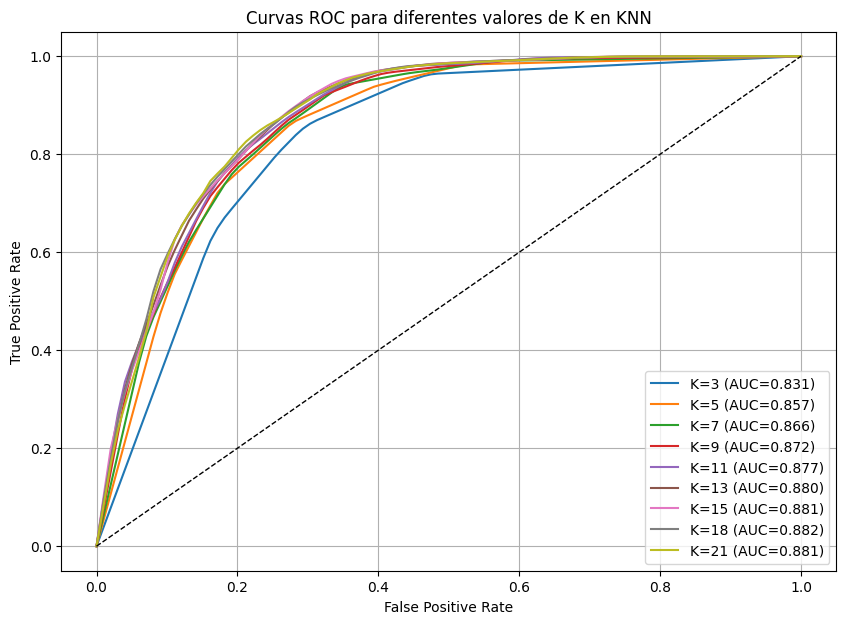

In [657]:
plt.figure(figsize=(10, 7))

for K, data in roc_results.items():
    plt.plot(data["fpr"], data["tpr"], label=f'K={K} (AUC={data["auc"]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC para diferentes valores de K en KNN')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Se evaluó el rendimiento del modelo KNN de clasificación variando el número de vecinos K y promediando el área bajo la curva (AUC) de la curva ROC, utilizando 5 folds en los conjuntos de entrenamiento para cada configuración. Se observa que valores pequeños de K presentan menor capacidad de predicción. A medida que K aumenta, el AUC mejora, alcanzando su valor máximo en 18, Sin embargo, a partir de K = 9 las mejoras son marginales.

In [658]:
clf = KNeighborsClassifier(n_neighbors=21)
clf.fit(X_train_bal, y_train_bal)
y_pred = clf.predict(X_test)

In [659]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [660]:
accuracy = y_test == y_pred
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)

print('Accuracy:',accuracy.mean())
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:',f1score)

Accuracy: 0.848587570621469
Precision: 0.8677165354330708
Recall: 0.9168053244592346
F1 Score: 0.8915857605177993


#### Matriz de confusión


In [661]:
confusion = confusion_matrix(y_test, y_pred)
confusion

array([[200,  84],
       [ 50, 551]], dtype=int64)

* Accuracy: El modelo clasifica correctamente el 84.85% de los casos. 

* Precision: Cuando el modelo predice la clase positiva (Graduate), acierta el 86.77% de las veces. Esto indica un bajo nivel de falsos positivos.

* Recall: El modelo detecta correctamente el 91.68% de las instancias que realmente pertenecen a la clase positiva. Esto significa que hay pocos falsos negativos.

* F1 Score: El equilibrio entre precision y recall, igualemente bueno con un 89.15%

## Feature Importance - KNN Regresión

### Codificación variable objetivo en regresión

Primero creamos la variable númerica a predecir, en este caso el promedio final, que se calculará tomando la media de los valores de 'Curricular units 2nd sem (grade)' y 'Curricular units 1st sem (grade)'

In [662]:
y_reg = (df["Curricular units 2nd sem (grade)"] + df["Curricular units 1st sem (grade)"]) / 2
y_reg.head()

0     0.000000
1    13.833333
2     0.000000
3    12.914286
4    12.666667
dtype: float64

### Variables categóricas

Utilizaremos nuevamente Kruskall-Wallis para evaluar si existe una diferencia entre las medianas de los diferentes grupos en las variables categóricas con relación a la variable objetivo.

In [663]:
resultados = {}

for col in variables_categoricas:
    grupos = [y_reg[X[col] == cat] for cat in X[col].unique()]
    
    if len(grupos) > 1:
        stat, p = kruskal(*grupos)
        resultados[col] = {"H": stat, "p_value": p}

# Crear DataFrame ordenado por H
kruskal_df = pd.DataFrame(resultados).T.sort_values("H", ascending=False)

print(kruskal_df)

                                    H        p_value
Course                     833.224518  5.136054e-167
Tuition fees up to date    303.291268   6.320154e-68
Application mode           240.218023   6.853992e-44
Scholarship holder         178.935572   8.276215e-41
Gender                     168.936692   1.263013e-38
Mother_occ                 100.535639   1.306256e-15
Debtor                      96.958293   7.080314e-23
Mother_quali                96.932923   2.235672e-16
P_quali                     95.576080   1.230791e-16
Father_quali                86.939034   6.616765e-14
Father_occ                  71.516957   4.214698e-10
Attendance                  52.339414   4.669087e-13
Marital                     46.663105   1.792278e-09
Application order           44.605232   5.606288e-08
Displaced                   36.632586   1.426274e-09
Educational special needs    2.131130   1.443343e-01
Nacionality                  0.229433   8.916190e-01
International                0.077627   7.8053

En este caso seleccionaremos las 3 variables más imporantes:
* Course
* Tuition fees up to date
* Application mode

### Variables numéricas

Para captar la relación entre las variables numéricas y la variable objetivo, también numérica utilizaremos correlación de Spearman, dado que no requiere de supuestos de normalidad y es útil cuando hay outliers o colas en la distribución

In [664]:
from scipy.stats import spearmanr

resultados = {}

for col in variables_numericas:
    corr, p = spearmanr(X[col], y_reg)
    resultados[col] = {"Corr": corr, "p_value": p}

spearman_df = pd.DataFrame(resultados).T.sort_values("Corr", ascending=False)

spearman_df

,Corr,p_value
Curricular units 2nd sem (grade),0.945004,0.000000e+00
Curricular units 1st sem (grade),0.917613,0.000000e+00
Curricular units 2nd sem (approved),0.714711,0.000000e+00
Curricular units 1st sem (approved),0.696827,0.000000e+00
Curricular units 2nd sem (enrolled),0.389259,5.153249e-160
Curricular units 1st sem (enrolled),0.379053,3.607921e-151
Admission grade,0.206520,8.107834e-44
Curricular units 2nd sem (evaluations),0.182508,1.930744e-34
Previous qualification (grade),0.171118,2.022600e-30
Curricular units 2nd sem (credited),0.109230,3.217348e-13


En este caso usaremos las 4 variables con mayor correlación:

* Curricular units 2nd sem (grade)
* Curricular units 1st sem (grade)
* Curricular units 2nd sem (approved)
* Curricular units 1st sem (approved)

### Variables seleccionadas

Variables con las que trabajaremos:

* 'Tuition fees up to date' 
* 'Application mode'
* 'Course' 
* 'Curricular units 2nd sem (approved)'
* 'Curricular units 1st sem (approved)'
* 'Curricular units 1st sem (grade)'
* 'Curricular units 2nd sem (grade)'

In [665]:
cols_seleccionadas_reg=['Tuition fees up to date','Application mode','Course','Curricular units 2nd sem (approved)',
'Curricular units 1st sem (approved)','Curricular units 1st sem (grade)','Curricular units 2nd sem (grade)']

In [666]:
X_reg = X[cols_seleccionadas_reg]
X_reg

,Tuition fees up to date,Application mode,Course,Curricular units 2nd sem (approved),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 2nd sem (grade)
0,1,17,171,0,0,0.000000,0.000000
1,0,15,9254,6,6,14.000000,13.666667
2,0,1,9070,0,0,0.000000,0.000000
3,1,17,9773,5,6,13.428571,12.400000
4,1,39,8014,6,5,12.333333,13.000000
...,...,...,...,...,...,...,...
4419,1,1,9773,5,5,13.600000,12.666667
4420,0,1,9773,2,6,12.000000,11.000000
4421,1,1,9500,1,7,14.912500,13.500000
4422,1,1,9147,5,5,13.800000,12.000000


## Tratamiento variables categóricas - Regresión

Usaremos nuevamente OneHot Encoding para las variables 'Application mode' y 'Course'.

In [667]:
ohe = OneHotEncoder(sparse=False, drop=None, handle_unknown="ignore") 

X_ohe  = ohe.fit_transform(X_reg[['Application mode', 'Course']]) 
ohe_columns = ohe.get_feature_names_out() 
X_ohe_df = pd.DataFrame(X_ohe, columns=ohe_columns, index=X.index) 

X_reg = pd.concat([X_reg.drop(columns=['Application mode', 'Course']), X_ohe_df], axis=1) 

X_reg.head()

c:\Users\USER\miniconda3\envs\ml_venv\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Tuition fees up to date,Curricular units 2nd sem (approved),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 2nd sem (grade),Application mode_1,Application mode_15,Application mode_16,Application mode_17,Application mode_18,...,Course_9147,Course_9238,Course_9254,Course_9500,Course_9556,Course_9670,Course_9773,Course_9853,Course_9991,Course_Otras
0,1,0,0,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,6,6,14.000000,13.666667,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,5,6,13.428571,12.400000,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1,6,5,12.333333,13.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Tratamiento variables numéricas - Regresión

Se usará RobustScaler para las variables numéricas.

In [668]:
num_columns = ['Curricular units 2nd sem (approved)', 'Curricular units 1st sem (approved)','Curricular units 1st sem (grade)','Curricular units 2nd sem (grade)']

X_reg[num_columns] = scaler.fit_transform(X_reg[num_columns])

X_reg.describe()

,Curricular units 2nd sem (approved),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 2nd sem (grade),Application mode_1,Application mode_15,Application mode_16,Application mode_17,Application mode_18,Application mode_39,...,Course_9147,Course_9238,Course_9254,Course_9500,Course_9556,Course_9670,Course_9773,Course_9853,Course_9991,Course_Otras
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,...,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,-0.141049,-0.097800,-0.685372,-0.762501,0.386076,0.006781,0.008590,0.197107,0.028029,0.177441,...,0.085895,0.080244,0.056962,0.173146,0.019439,0.060579,0.074819,0.043400,0.060579,0.002712
std,0.753691,1.031413,2.018193,2.017087,0.486903,0.082078,0.092291,0.397859,0.165074,0.382085,...,0.280241,0.271701,0.231796,0.378417,0.138079,0.238583,0.263129,0.203778,0.238583,0.052017
min,-1.250000,-1.666667,-5.119048,-4.722581,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.750000,-0.666667,-0.535714,-0.561290,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.250000,0.333333,0.464286,0.438710,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.750000,7.000000,2.745536,2.466359,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Separación de los Datasets - Regresión

In [669]:
X_train_full_reg, X_test_reg, y_train_full_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=1) #stratify mantiene las proporciones de la clase 
X_train_reg, X_val_reg, y_train_reg, y_val_reg = train_test_split(X_train_full_reg, y_train_full_reg, test_size=0.25, random_state=1)

## Grid-Search manual con KFold - KNN regresión

In [670]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_log_error

kf = KFold(n_splits=5, shuffle=True, random_state=1) 

rmsle_val = [] 
best_rmsle = 1.0

for k in range(1, 22):
    fold_rmsles = []
    
    for train_idx, val_idx in kf.split(X_train_reg):
        X_train_fold = X_train_reg.iloc[train_idx]
        y_train_fold = y_train_reg.iloc[train_idx]
        
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(X_train_fold, y_train_fold)
        y_pred = knn.predict(X_val_reg)
        
        rmsle = np.sqrt(mean_squared_log_error(y_val_reg, y_pred))
        fold_rmsles.append(rmsle)
    
    mean_rmsle = np.mean(fold_rmsles)
    rmsle_val.append(mean_rmsle)
    
    if mean_rmsle < best_rmsle:
        best_rmsle = mean_rmsle
        best_k = k

print(f"Mejor k: {best_k} con RMSLE promedio = {best_rmsle:.4f}")
print("RMSLE por k:", best_rmsle)

Mejor k: 6 con RMSLE promedio = 0.0297
RMSLE por k: 0.02966236402956679


El mejor número de K vecinos en KNN para clasificación, en este caso es de 6

## Métricas evaluación

In [671]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score

In [672]:
knn = KNeighborsRegressor(n_neighbors=6)
knn.fit(X_train_reg, y_train_reg)
y_pred = knn.predict(X_test_reg)

### Gráfica valores reales vs predichos

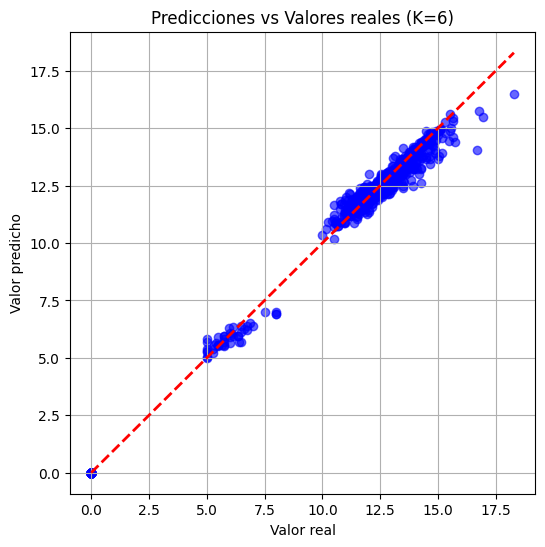

In [673]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test_reg, y_pred, alpha=0.6, color="blue")
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 
         '--', color='red', linewidth=2)
plt.xlabel("Valor real")
plt.ylabel("Valor predicho")
plt.title(f"Predicciones vs Valores reales (K={best_k})")
plt.grid(True)
plt.show()

Los puntos azules (valores reales) se encuentran muy cercanos a la línea roja, lo que indica que el modelo de regresión de KNN con k=6 tiene buena capacidad de ajuste y un bajo error en el RMSLE. Los diferentes grupos definidos que se observan se deben a la distribución de las variables utilizadas para la predicción, ya que un gran porcentaje de las notas (empleadas para construir la variable objetivo) presentaban concentraciones elevadas de valores cercanos a 0. Por esta misma razón se utilizó RobustScaler para escalar las variables numéricas y reducir el impacto de dichos valores atípicos en el modelo.

In [674]:
r2_valid = r2_score(y_test_reg, y_pred)
mae_valid = mean_absolute_error(y_test_reg, y_pred)
evs_valid = explained_variance_score(y_test_reg, y_pred, multioutput='uniform_average')
rmse_valid = np.sqrt(mean_squared_error(y_test_reg, y_pred))
rmsle_valid = np.sqrt(mean_squared_log_error(y_test_reg, y_pred))

print('R2 Valid:',r2_valid)
print('EVS Valid:', evs_valid)
print('MAE Valid:', mae_valid)
print('RMSE Valid:',rmse_valid)
print('RMSLE Valid:', rmsle_valid)

R2 Valid: 0.9946456492878558
EVS Valid: 0.9947483776258838
MAE Valid: 0.2208141958223786
RMSE Valid: 0.3555610788827271
RMSLE Valid: 0.027576884386674876


* R2: El modelo explica el 99.4% de la variabilidad en los datos de prueba. Esto indica un ajuste extremadamente alto. Debido en parte a la codificación de la variable objetivo, la cual se codificó promediando las notas del primer y segundo semestre.

* EVS: La varianza de los errores es muy baja y que las predicciones siguen de cerca la variabilidad real de los datos.

* MAE: En promedio, las predicciones se desvían solo 0.22 unidades de los valores reales.

* RMSE: El error cuadrático medio es bajo, lo que significa que no hay errores grandes dominando el desempeño.

* RMSLE: El error relativo en escala logarítmica es mínimo, lo que implica que el modelo no solo predice bien en magnitudes grandes, sino también en valores pequeños.